In [2]:
import pandas as pd
from ast import literal_eval
from collections import Counter

# 0. Data preparation

## 0.0 Download and upload

In [108]:
input_folder_path='./'

In [109]:
output_folder_path = '../movie_classifier/model/'

In [4]:
file_name = 'movies_metadata.csv'

In [110]:
movies = pd.read_csv(input_folder_path+file_name, 
                     usecols= ['id','title', 'overview', 'genres'],
                     dtype={"id": str, "title": str, "overview": str},
                     converters={"genres": literal_eval})

In [111]:
movies.shape

(45466, 4)

## 0.1 Filtering

In [7]:
movies[movies.title.isna()]

,genres,id,overview,title
19729,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",82663,British soldiers force a recently captured IRA...,NaN
19730,"[{'name': 'Carousel Productions', 'id': 11176}...",1997-08-20,Released,NaN
29502,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",122662,Third film of the Mardock Scramble series.,NaN
29503,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...",2012-09-29,Released,NaN
35586,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",249260,A group of skiers are terrorized during spring...,NaN
35587,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...",2014-01-01,Released,NaN


In [8]:
movies = movies[movies.title.notna()]

In [9]:
movies = movies[movies.overview.str.len()>50]

In [10]:
movies['id'] = movies.id.astype(int)

In [11]:
movies.shape

(43971, 4)

In [12]:
sum(movies.genres.apply(len)==0)

2061

In [13]:
movies = movies[movies.genres.apply(len)>0]

In [14]:
movies.shape

(41910, 4)

In [15]:
sum(movies.genres.apply(len)==0)

0

## 0.2 Chosing an unique genre

In [16]:
all_genres = [element for list_ in movies.genres for element in list_]

In [17]:
genres_freq = dict(Counter([element["name"] for element in all_genres]).most_common())

In [18]:
len(genres_freq)

20

In [19]:
genres_freq

{'Drama': 19889,
 'Comedy': 12652,
 'Thriller': 7543,
 'Romance': 6638,
 'Action': 6526,
 'Horror': 4625,
 'Crime': 4249,
 'Documentary': 3824,
 'Adventure': 3458,
 'Science Fiction': 3007,
 'Family': 2712,
 'Mystery': 2445,
 'Fantasy': 2275,
 'Animation': 1896,
 'Foreign': 1579,
 'Music': 1566,
 'History': 1375,
 'War': 1306,
 'Western': 1027,
 'TV Movie': 744}

In [20]:
genres_list = list(genres_freq.keys())

In [21]:
num_of_genres=10

In [22]:
genres_subset = genres_list[:num_of_genres]

In [23]:
genres_subset

['Drama',
 'Comedy',
 'Thriller',
 'Romance',
 'Action',
 'Horror',
 'Crime',
 'Documentary',
 'Adventure',
 'Science Fiction']

In [24]:
movies['accepted_genres'] = movies.genres.apply(
    lambda x: list(set([elem_["name"] for elem_ in x ])\
                  .intersection(set(genres_subset))))

In [25]:
movies[movies.accepted_genres.apply(len)==0].head(3)

,genres,id,overview,title,accepted_genres
124,"[{'id': 14, 'name': 'Fantasy'}]",27793,A young boy must restore order when a group of...,The Neverending Story III: Escape from Fantasia,[]
309,"[{'id': 16, 'name': 'Animation'}]",22586,The beautiful princess Odette is transformed i...,The Swan Princess,[]
377,"[{'id': 14, 'name': 'Fantasy'}]",10395,Publisher Will Randall becomes a werewolf and ...,Wolf,[]


In [26]:
movies[movies.accepted_genres.apply(len)==0].shape, movies.shape

((1429, 5), (41910, 5))

In [27]:
movies_reduced = movies[movies.accepted_genres.apply(len)>0].copy()

In [28]:
sum(movies_reduced.accepted_genres.apply(len)==0)

0

In [29]:
movies_reduced['unique_genre'] = movies_reduced.accepted_genres.apply(lambda x: x[0])

In [30]:
movies_reduced.head(3)

,genres,id,overview,title,accepted_genres,unique_genre
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story,[Comedy],Comedy
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Jumanji,[Adventure],Adventure
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men,"[Comedy, Romance]",Comedy


In [31]:
movies_reduced.shape

(40481, 6)

## 0.3 Vectorization

In [32]:
num_words=10000

In [34]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)

In [35]:
#all_overview = movies_reduced.overview.str.replace('[^a-zA-Z0-9\s]', '', regex=True).str.lower()

In [36]:
tokenizer.fit_on_texts(movies_reduced.overview)

In [37]:
len(tokenizer.word_index)

81888

In [38]:
tokenized_overviews = tokenizer.texts_to_sequences(movies_reduced.overview.str.split())

In [127]:
movies_reduced.overview.str.split()

0        [Led, by, Woody,, Andy's, toys, live, happily,...
1        [When, siblings, Judy, and, Peter, discover, a...
2        [A, family, wedding, reignites, the, ancient, ...
3        [Cheated, on,, mistreated, and, stepped, on,, ...
4        [Just, when, George, Banks, has, recovered, fr...
                               ...                        
45458    [A, film, archivist, revisits, the, story, of,...
45459    [It's, the, year, 3000, AD., The, world's, mos...
45460    [Yet, another, version, of, the, classic, epic...
45462    [An, artist, struggles, to, finish, his, work,...
45463    [When, one, of, her, hits, goes, wrong,, a, pr...
Name: overview, Length: 40481, dtype: object

In [39]:
genre_labels = movies_reduced.unique_genre.apply(lambda x: genres_subset.index(x)).tolist()

## 1.4 Saving

In [40]:
import pickle

In [116]:
with open(output_folder_path+'genres_subset.txt', "wb") as fp:
    pickle.dump(genres_subset, fp)

In [117]:
with open(output_folder_path+'tokenizer.txt', "wb") as fp:
    pickle.dump(tokenizer, fp)

In [44]:
with open(folder_path+'vect/genres_subset.txt', "rb") as fp2:   # Unpickling
    genres_subset_2= pickle.load(fp2)

In [45]:
with open(folder_path+'vect/tokenizer.txt', "rb") as fp2:   # Unpickling
    tokenizer2= pickle.load(fp2)

# 2. The model

## 2.1 Data encoding

In [46]:
import numpy as np

In [47]:
vectorized_overviews = np.zeros((len(tokenized_overviews), num_words), bool)

In [48]:
for i, tokenized_ov in enumerate(tokenized_overviews):
    vectorized_overviews[i, tokenized_ov]=True

In [49]:
vectorized_overviews

array([[False,  True, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       ...,
       [False,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [50]:
from keras.utils import to_categorical

In [51]:
genre_one_hot = to_categorical(genre_labels)

In [52]:
genre_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 2.2 Split train test

In [53]:
test_size= 10000

In [54]:
len(vectorized_overviews)

40481

In [55]:
vectorized_overviews_train = vectorized_overviews[:-test_size]

In [56]:
vectorized_overviews_test = vectorized_overviews[-test_size:]

In [57]:
len(vectorized_overviews_train),len(vectorized_overviews_test)

(30481, 10000)

In [58]:
genre_one_hot_train = genre_one_hot[:-test_size]
genre_one_hot_test = genre_one_hot[-test_size:]

In [59]:
len(genre_one_hot_train),len(genre_one_hot_test)

(30481, 10000)

## 2.3 Architecture

In [60]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_of_genres, activation='softmax'))

2021-07-09 10:02:19.219837: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-09 10:02:19.220570: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-09 10:02:19.226423: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [61]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
history = model.fit(vectorized_overviews_train,
                    genre_one_hot_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.1)

2021-07-09 10:02:24.206399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-09 10:02:24.224502: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/10
54/54 [==============================] - 3s 51ms/step - loss: 1.8231 - accuracy: 0.3536 - val_loss: 1.4222 - val_accuracy: 0.5133
Epoch 2/10
54/54 [==============================] - 3s 47ms/step - loss: 1.1732 - accuracy: 0.6035 - val_loss: 1.3787 - val_accuracy: 0.5316
Epoch 3/10
54/54 [==============================] - 3s 52ms/step - loss: 0.9085 - accuracy: 0.6964 - val_loss: 1.4299 - val_accuracy: 0.5238
Epoch 4/10
54/54 [==============================] - 3s 49ms/step - loss: 0.7478 - accuracy: 0.7504 - val_loss: 1.5453 - val_accuracy: 0.5169
Epoch 5/10
54/54 [==============================] - 3s 53ms/step - loss: 0.6013 - accuracy: 0.7985 - val_loss: 1.6748 - val_accuracy: 0.5087
Epoch 6/10
54/54 [==============================] - 3s 48ms/step - loss: 0.4935 - accuracy: 0.8391 - val_loss: 1.8146 - val_accuracy: 0.5077
Epoch 7/10
54/54 [==============================] - 3s 49ms/step - loss: 0.3880 - accuracy: 0.8791 - val_loss: 1.9897 - val_accuracy: 0.5008
Epoch 8/10
54

In [64]:
import matplotlib.pyplot as plt

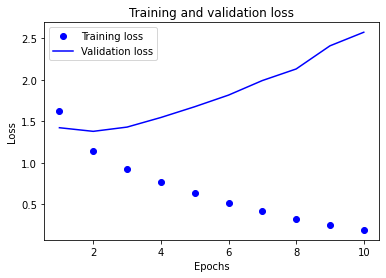

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

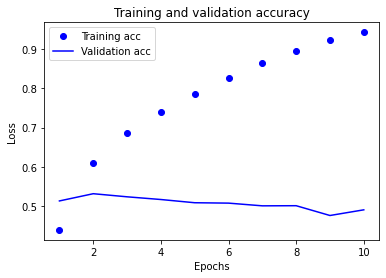

In [67]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [68]:
model.evaluate(vectorized_overviews_test, genre_one_hot_test)

313/313 [==============================] - 6s 18ms/step - loss: 2.5042 - accuracy: 0.4967


[2.5041959285736084, 0.4966999888420105]

In [113]:
model.save(output_folder_path+'nn/')

INFO:tensorflow:Assets written to: ../movie_classifier/model/nn/assets


In [69]:
vectorized_overviews_test[0].reshape(10000,1).shape

(10000, 1)

In [70]:
probs = model.predict(vectorized_overviews_test[0].reshape(1,10000))

In [71]:
genres_subset[np.argmax(probs)]

'Documentary'

In [73]:
probs

array([[1.5234046e-01, 5.5949181e-02, 2.1030122e-04, 1.6056384e-03,
        2.5224947e-05, 1.1704992e-04, 3.3921431e-04, 7.8909540e-01,
        1.3042084e-04, 1.8720051e-04]], dtype=float32)

In [72]:
np.argmax(probs)

7

In [103]:
genre_one_hot_test[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [74]:
predictions= model.predict(vectorized_overviews_test)

In [101]:
predictions[1]

array([2.5669897e-01, 7.1442342e-01, 3.2550513e-05, 1.7906590e-04,
       1.0018373e-02, 3.0069128e-05, 3.2836309e-04, 9.3835683e-07,
       1.7930651e-02, 3.5764356e-04], dtype=float32)

In [104]:
probs

array([[1.5234046e-01, 5.5949181e-02, 2.1030122e-04, 1.6056384e-03,
        2.5224947e-05, 1.1704992e-04, 3.3921431e-04, 7.8909540e-01,
        1.3042084e-04, 1.8720051e-04]], dtype=float32)

In [105]:
genres_subset[np.argmax(predictions[1])]

'Comedy'

In [121]:
movies_reduced.loc[test_size]

genres                           [{'id': 99, 'name': 'Documentary'}]
id                                                             14287
overview           The Year of the Yao is a documentary film tell...
title                                            The Year of the Yao
accepted_genres                                        [Documentary]
unique_genre                                             Documentary
Name: 10000, dtype: object

In [124]:
print(movies_reduced.loc[test_size].overview)

The Year of the Yao is a documentary film telling the first year of basketball player Yao Ming in the United States.


# 3. Loading

In [76]:
from keras.models import load_model

In [115]:
model2 = load_model(output_folder_path+'nn/')

In [81]:
model2.evaluate(vectorized_overviews_test, genre_one_hot_test)

313/313 [==============================] - 4s 11ms/step - loss: 2.5042 - accuracy: 0.4967


[2.5041959285736084, 0.4966999888420105]